In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import sys
sys.path.insert(1, '</PATH/TO/DIR/>WAVE/')
import identify_rings as idr
import seaborn as sns
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = '<PATH/TO/DIR/>WAVE/Molecular_counting/Nanorings/'

In [4]:
def kde_estimation(data,bins,bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(data)[:, np.newaxis])
    X_plot = np.linspace(np.min(data), np.max(data), bins)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return log_dens,X_plot

# WAVE nanoring quantification

In [9]:
image = io.imread(PATH + '/example_images/231111_latb_1_1_SIR.tif')

In [10]:
image.shape

(5, 475, 475)

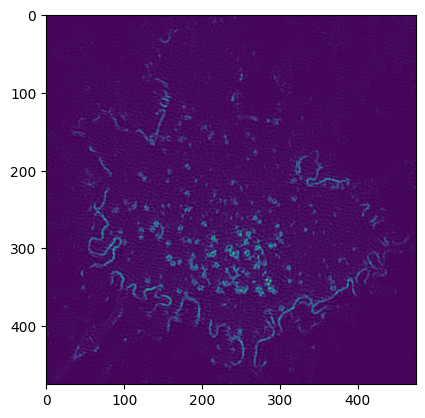

In [11]:
plt.imshow(image[0])

In [12]:
threshold_otsu(image[2])

191.8429

40.0 3.2 0.7560975609756098


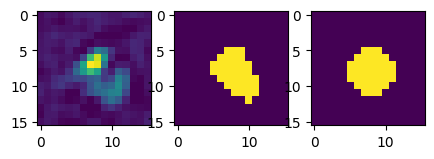

72.0 4.0 0.75


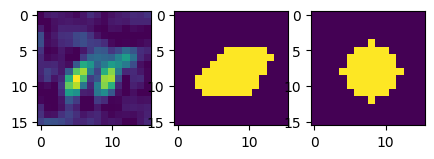

91.0 3.2 0.717948717948718


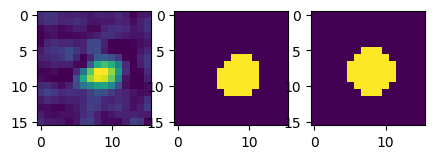

93.0 3.7 0.8541666666666666


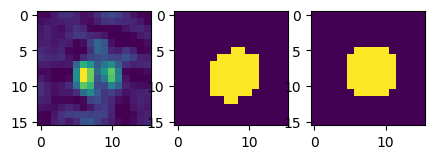

96.0 3.2 0.7804878048780488


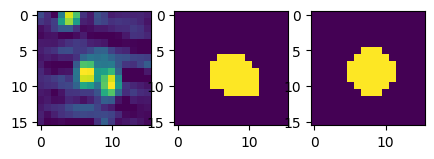

104.0 2.9000000000000004 0.8214285714285714


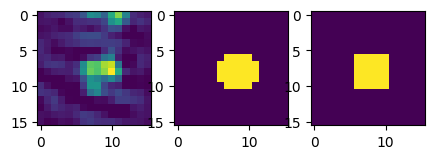

132.0 3.2 0.8604651162790697


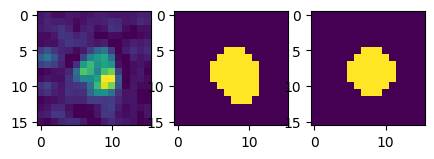

147.0 3.7 0.7254901960784313


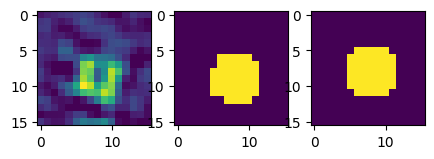

148.0 3.7 0.7454545454545455


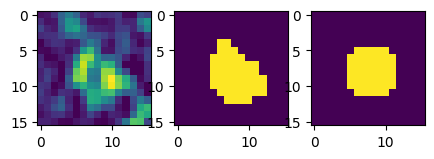

150.0 3.2 0.8108108108108109


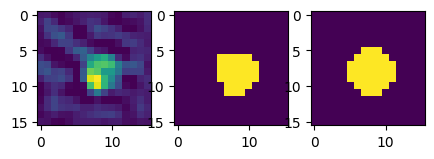

156.0 4.300000000000001 0.828125


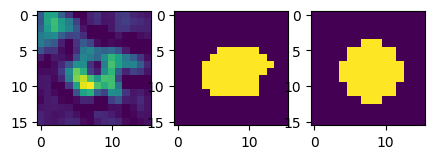

160.0 3.2 0.8372093023255814


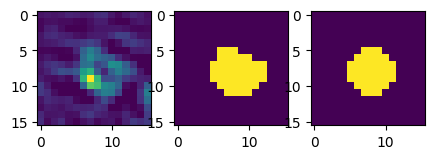

42.0 3.0 0.8387096774193549


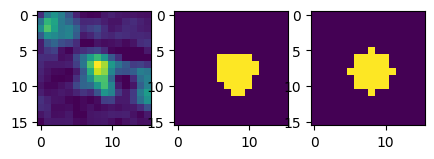

45.0 3.0 0.71875


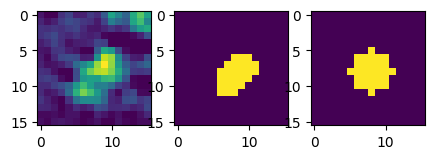

53.0 3.0 0.7352941176470589


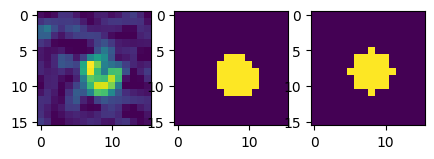

66.0 3.2 0.7209302325581395


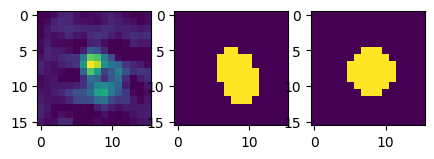

76.0 3.7 0.9111111111111111


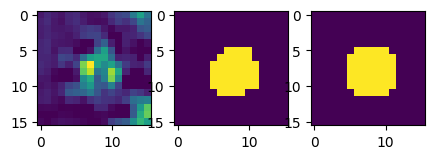

81.0 3.7 0.8936170212765957


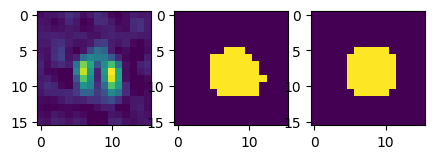

83.0 2.9000000000000004 0.8214285714285714


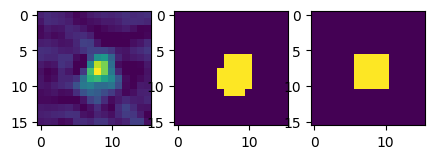

87.0 3.2 0.75


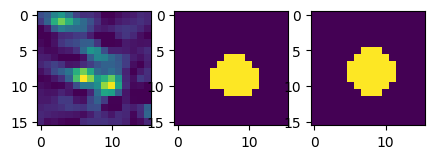

89.0 3.2 0.813953488372093


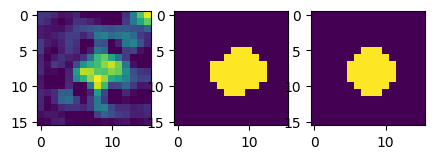

92.0 4.0 0.7636363636363637


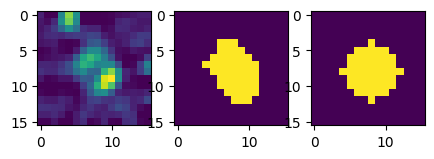

97.0 4.5 0.782051282051282


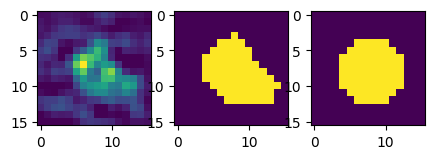

128.0 3.2 0.7619047619047619


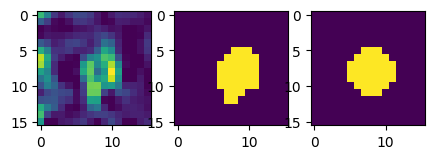

130.0 4.2 0.8135593220338984


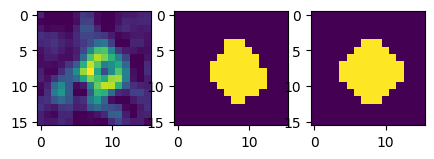

133.0 3.2 0.7906976744186046


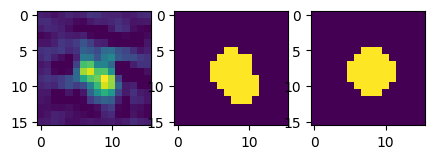

145.0 4.300000000000001 0.7936507936507936


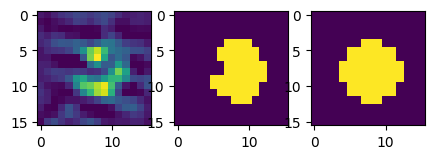

150.0 3.7 0.8913043478260869


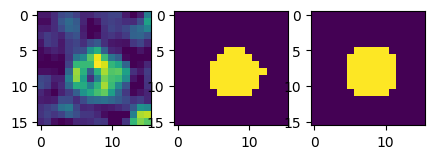

161.0 4.2 0.8448275862068966


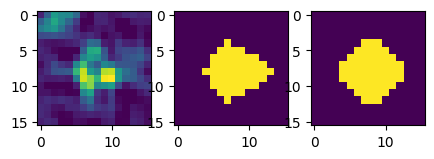

165.0 3.2 0.925


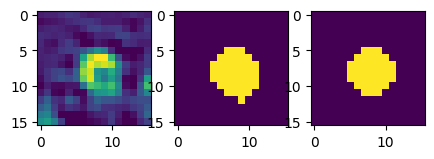

75.0 3.7 0.8333333333333334


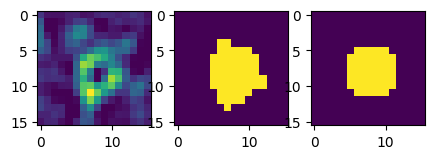

84.0 3.2 0.7272727272727273


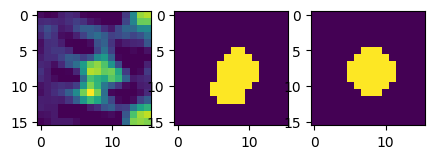

88.0 3.2 0.775


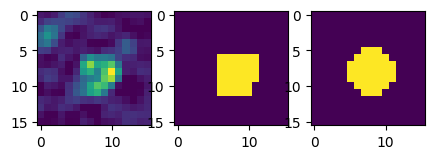

94.0 3.2 0.7317073170731707


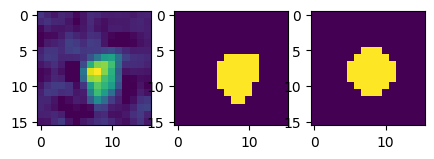

98.0 4.2 0.7384615384615385


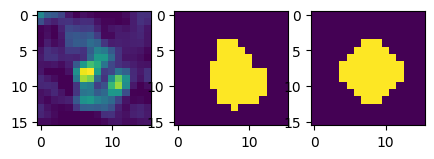

99.0 3.2 0.8108108108108109


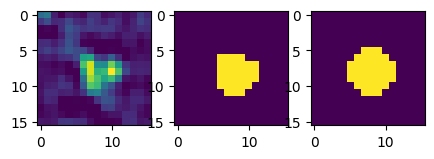

101.0 3.7 0.76


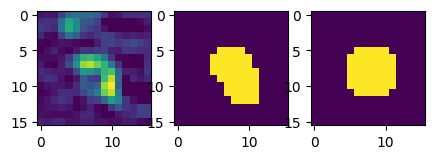

106.0 4.2 0.7536231884057971


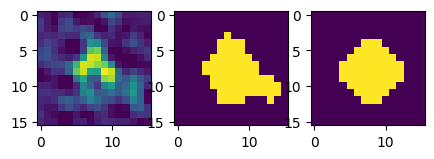

114.0 3.2 0.7368421052631579


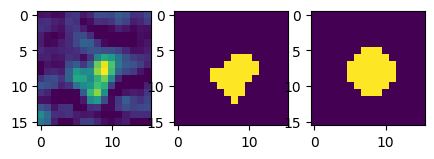

124.0 3.2 0.75


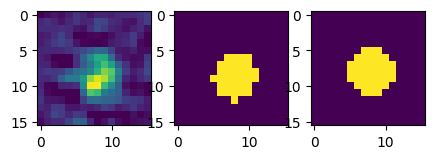

126.0 4.2 0.7142857142857143


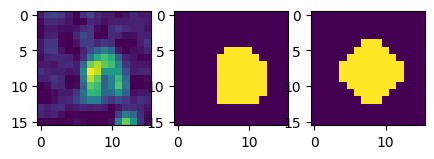

140.0 4.300000000000001 0.75


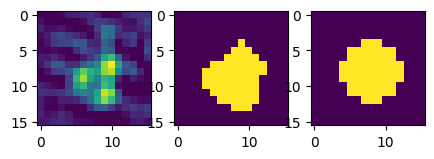

157.0 3.7 0.7391304347826086


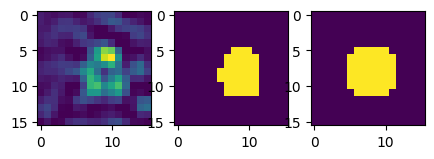

172.0 3.2 0.8947368421052632


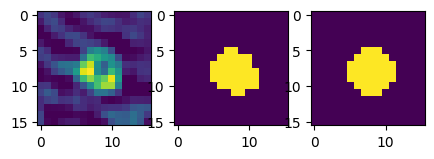

173.0 3.7 0.7169811320754716


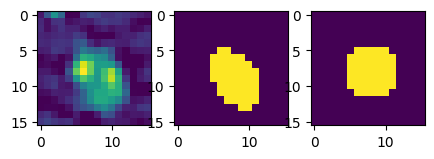

175.0 3.2 0.7857142857142857


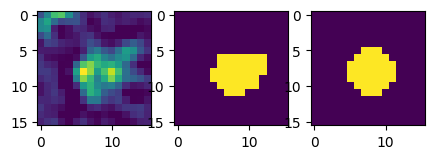

177.0 3.2 0.7441860465116279


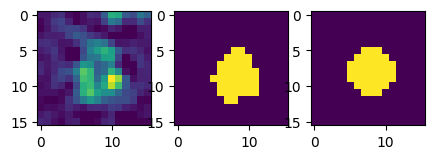

91.0 3.2 0.7142857142857143


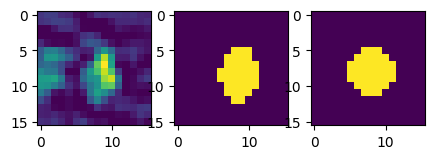

104.0 3.7 0.7551020408163265


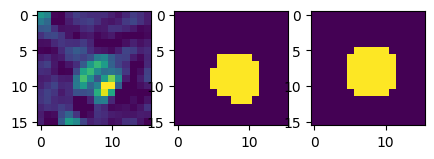

119.0 4.5 0.7215189873417721


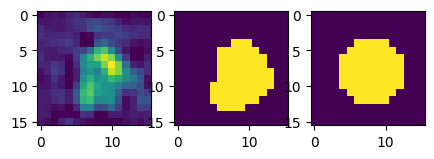

120.0 3.2 0.7142857142857143


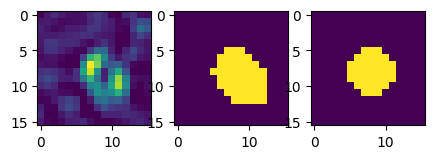

130.0 3.0 0.8064516129032258


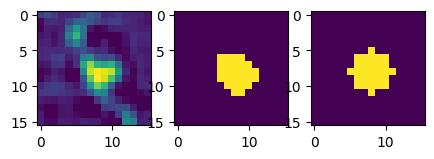

134.0 4.5 0.8133333333333334


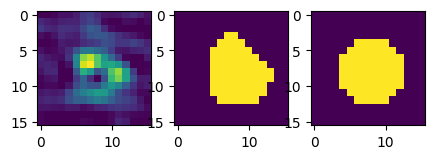

137.0 4.0 0.8181818181818182


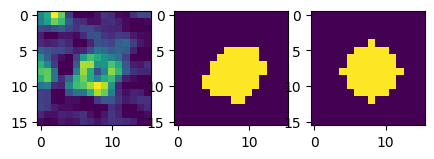

138.0 2.9000000000000004 0.71875


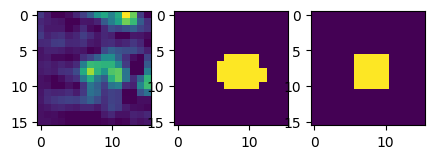

145.0 3.2 0.85


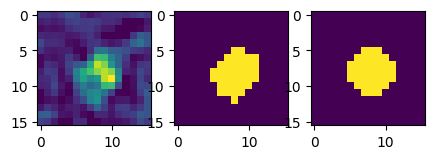

151.0 3.0 0.84375


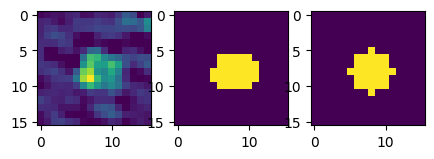

158.0 5.0 0.7272727272727273


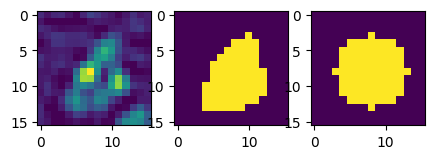

173.0 3.7 0.8235294117647058


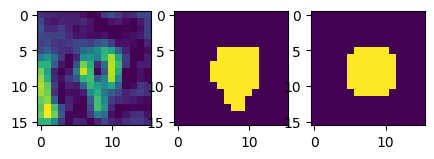

177.0 4.0 0.8431372549019608


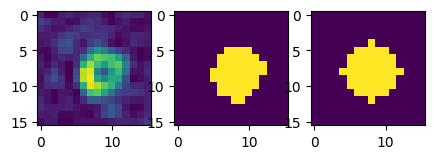

183.0 4.2 0.7333333333333333


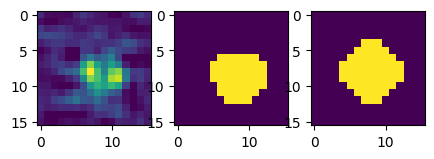

200.0 3.2 0.75


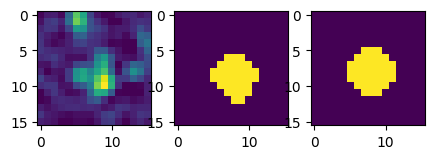

201.0 3.2 0.7857142857142857


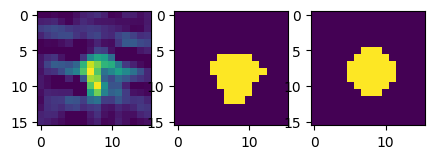

203.0 3.2 0.7111111111111111


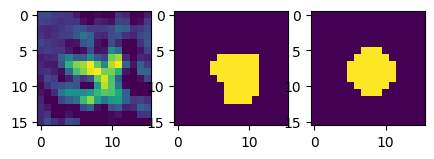

215.0 3.7 0.8222222222222222


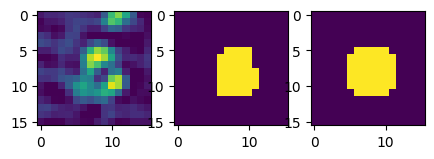

219.0 3.7 0.8297872340425532


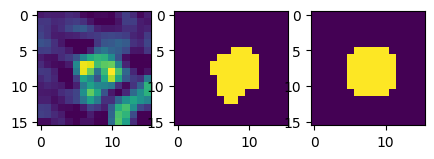

44.0 3.0 0.7647058823529411


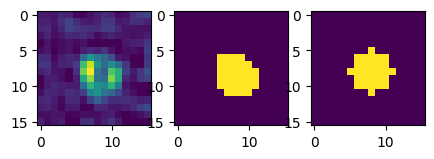

72.0 3.2 0.7317073170731707


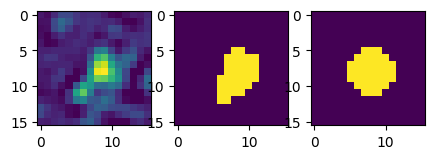

74.0 4.2 0.84375


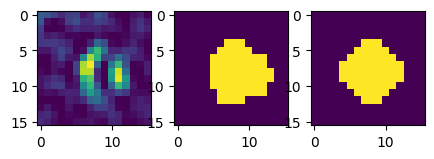

85.0 3.7 0.7916666666666666


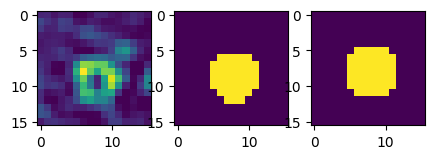

95.0 3.2 0.782608695652174


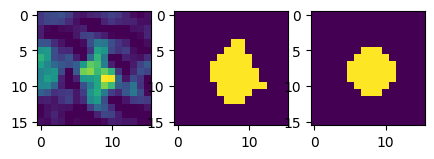

103.0 3.2 0.717391304347826


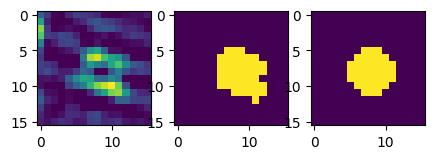

111.0 3.2 0.8157894736842105


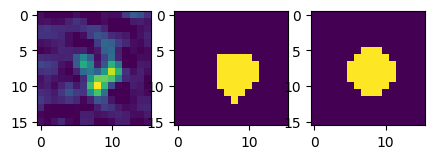

117.0 4.2 0.7666666666666667


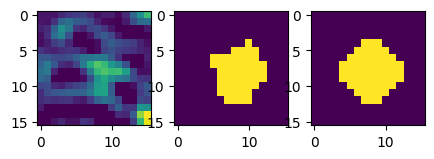

122.0 4.5 0.725


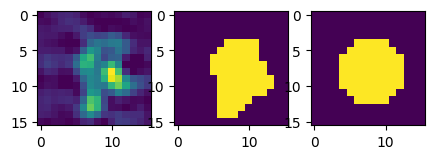

123.0 3.2 0.717391304347826


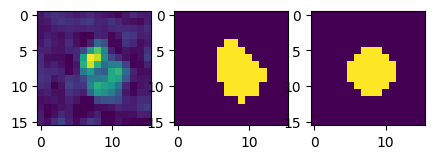

124.0 4.0 0.7547169811320755


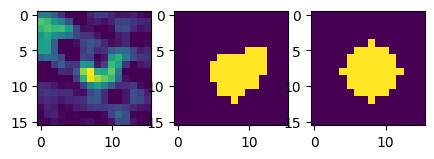

126.0 3.0 0.7878787878787878


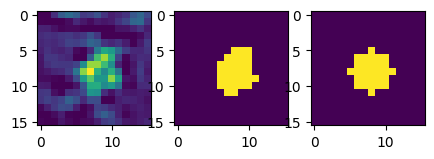

128.0 3.7 0.8936170212765957


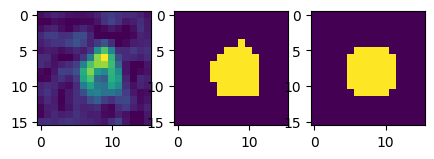

131.0 3.0 0.75


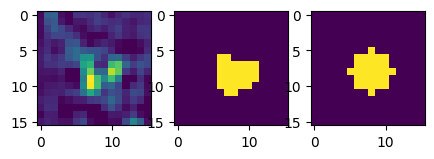

143.0 3.2 0.7948717948717948


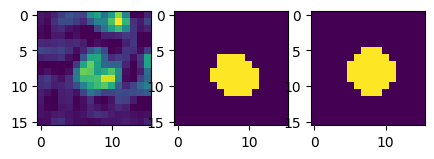

144.0 4.5 0.7317073170731707


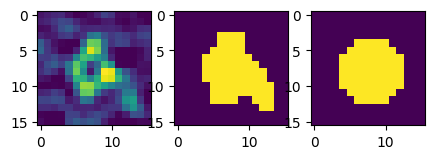

149.0 3.0 0.8181818181818182


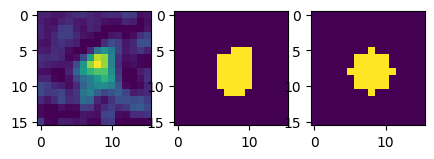

161.0 2.9000000000000004 0.7586206896551724


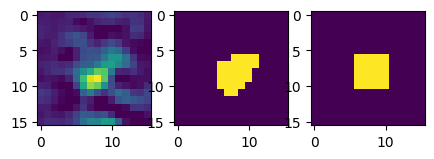

173.0 4.5 0.7432432432432432


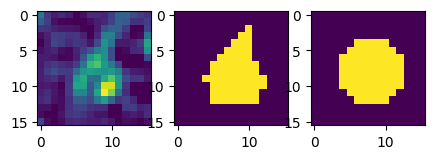

174.0 4.0 0.8627450980392157


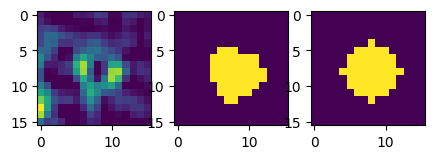

208.0 3.2 0.8378378378378378


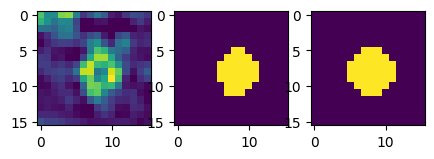

209.0 3.2 0.7692307692307693


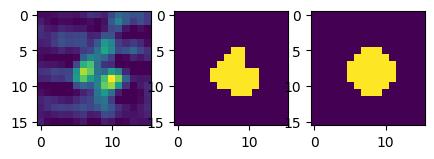

In [13]:
rings = pd.DataFrame()
opt_threshold = 200
for i in range(image.shape[0]):
    prop, label_mask_clean = idr.seg_cells(image[i], opt_threshold, 1.2, 25, 100, False)
    features = pd.DataFrame()
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
#         plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                     'y': prop[j].centroid[1],'length': prop[j].major_axis_length,'frame': i}])
    results = idr.ring_fitting(image[i], label_mask_clean, features, 8, 0.71, True)
    if "intensity" in results:
        rings = rings.append(results[results.intensity>0])
rings['final_intensity'] = rings['intensity'] - rings['background']


# Generate plot

In [14]:
g4 = pd.read_csv(PATH + 'csv_data/g4.csv',index_col=0)
g3 = pd.read_csv(PATH + 'csv_data/g3.csv',index_col=0)
g2 = pd.read_csv(PATH + 'csv_data/g2.csv',index_col=0)
g1 = pd.read_csv(PATH + 'csv_data/g1.csv',index_col=0)

In [15]:
total = g1
total = total.append(g2)
total = total.append(g3)
total = total.append(g4)

In [16]:
# Convert fluorescent intensity to number of molecules based on the standard curve(38.8), 
# corrected by fluorescence loss after fixation (33.7/31.8) and percentage of eGFP-tagged subunits (0.88)
total['number'] = total.final_intensity/(38.8*(33.7/31.8))/0.88

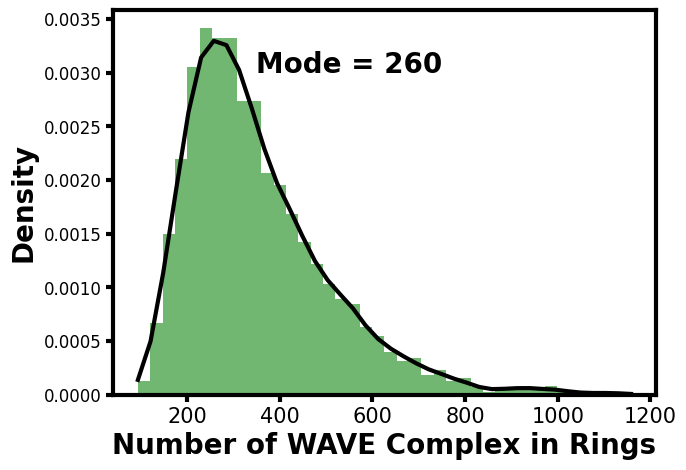

In [17]:
fig,ax = plt.subplots(figsize = (7,5))
distribution = total.number
bins = 40
bandwidth = 25
log_dens,X_plot = kde_estimation(distribution,bins,bandwidth)
plt.hist(distribution,bins =bins,density = True,color = '#138613',alpha = 0.6)
plt.plot(X_plot[:, 0], np.exp(log_dens)[:],'-',color = 'black',lw = 3,alpha = 1)
plt.xlabel('Number of WAVE Complex in Rings',size = 20,fontweight = 'bold')
plt.ylabel('Density',size = 20,fontweight = 'bold')
mode = X_plot[log_dens.argmax()]
# plt.text(1000,0.001,"N = " + str(len(distribution)),size = 13)
plt.text(350,0.003,"Mode = "+ f'{float(f"{mode[0]:.2g}"):g}',size = 20,weight = 'bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(size = 15)
plt.yticks (size= 12)
plt.savefig(PATH + "FigS3D_WAVE_Count.png",bbox_inches = 'tight',dpi = 300)